# Recurrent Neural Networks Demo
This is a truncated and slightly modified version of an RNN demo by 95-865 Fall 2017 TA Runshan Fu

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Sentiment Analysis with the IMDb Dataset
In this demo, we will implement RNN models for sentiment analysis on IMDB reviews. We will start from the original review texts and predict sentiments (positive or negative) for each review. The example is borrowed from the book *Deep Learning with Python* by Francois Chollet.

#### Load the dataset
We directly load the data as lists of intergers from keras. We restrict the movie reviews to the top 10,000 most common words, and cut the reviews after 100 words.

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# load the dataset and only keep the top words (most frequently occurring)
max_words = 2000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

# turn the lists of integers into a 2D integer tensor of shape `(samples, maxlen)`
x_train = sequence.pad_sequences(x_train, maxlen=100)
x_test = sequence.pad_sequences(x_test, maxlen=100)

/Users/georgehc/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Use pre-trained word embeddings
We use GloVe embeddings instead of learning our own task-specific word embedding. First download the pre-computed embeddings from 2014 English Wikipedia on https://nlp.stanford.edu/projects/glove/ (specifically the one with 6 billion tokens, `globe.6B.zip`). Unzip it (so that `glove.6B.100d.txt` is located in the directory `./glove/`).

In [3]:
# pre-process the embeddings
embeddings_index = {}

# we will use the 100-dimensional embedding vectors
with open("./glove/glove.6B.100d.txt") as f:
    # each row represents a word vector
    for line in f:
        values = line.split()
        # the first part is word
        word = values[0]
        # the rest of the values form the embedding vector
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [4]:
# prepare the GloVe word embeddings matrix
embedding_dim = 100

# word index is a dictinary that maps each word to its index
word_index = imdb.get_word_index()
# we first initialize the embedding matrix with zeros
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    # we get the word embeddings for each word from GloVe
    embedding_vector = embeddings_index.get(word)
    # we only look at top 10000 words
    if i < max_words:
        # if the embedding vector for the word exists in GloVe, we use it as the corresponding row in the 
        # embedding matrix; otherwise we leave the row as all zeros
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

del embeddings_index

#### Forward Network with Embeddings

In [5]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
# initialize the model
feedforward_model = Sequential()
# add the embedding layer; it takes 3 arguments: the total number of words (10000), 
# embedding dimension(100), and the input length (100)--the last argument is required 
# as we are going to connect Flatten then Dense layers (without it, the shape of
# the dense outputs cannot be computed).
feedforward_model.add(Embedding(max_words, embedding_dim, input_length=100))
# then flatten the 3D tensor into a 2D matrix as the input for the subsequent layer
feedforward_model.add(Flatten())
# add a dense layer with 32 nodes
feedforward_model.add(Dense(32, activation='relu'))
# add a logistic regression binary classifier
feedforward_model.add(Dense(1, activation='sigmoid'))
feedforward_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          200000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 520,065
Trainable params: 520,065
Non-trainable params: 0
_________________________________________________________________


In [6]:
# load the GloVe embeddings in the model
feedforward_model.layers[0].set_weights([embedding_matrix])
# set the embedding layer to be not trainable, so the weights do not change during the training
feedforward_model.layers[0].trainable = False

In [7]:
# compile and train the model
feedforward_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = feedforward_model.fit(x_train, y_train,
                                validation_split=0.2,
                                epochs=10,
                                batch_size=32)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 41s 2ms/step - loss: 0.7072 - acc: 0.5016 - val_loss: 0.6930 - val_acc: 0.4938
Epoch 2/10
20000/20000 [==============================] - 44s 2ms/step - loss: 0.6930 - acc: 0.4987 - val_loss: 0.6929 - val_acc: 0.5088
Epoch 3/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.6911 - acc: 0.5081 - val_loss: 0.6919 - val_acc: 0.5204
Epoch 4/10
20000/20000 [==============================] - 39s 2ms/step - loss: 0.6849 - acc: 0.5340 - val_loss: 0.6894 - val_acc: 0.5480
Epoch 5/10
20000/20000 [==============================] - 35s 2ms/step - loss: 0.6681 - acc: 0.5816 - val_loss: 0.6985 - val_acc: 0.5294
Epoch 6/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.6432 - acc: 0.6279 - val_loss: 0.7116 - val_acc: 0.5654
Epoch 7/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.6133 - acc: 0.6596 - val_loss: 0.7251 - val_acc:

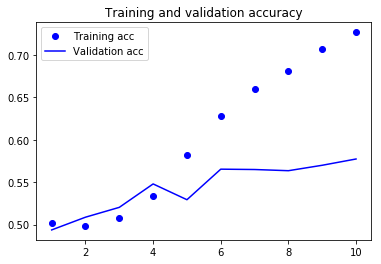

In [8]:
# plot the accuracy rates for each epoch on training and validation data
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

#### LSTM

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
rnn_model = Sequential()
rnn_model.add(Embedding(max_words, embedding_dim))
rnn_model.add(LSTM(embedding_dim))
rnn_model.add(Dense(1, activation='sigmoid'))
# load the GloVe embeddings in the model
rnn_model.layers[0].set_weights([embedding_matrix])
rnn_model.layers[0].trainable = False

rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         200000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 280,501
Trainable params: 80,501
Non-trainable params: 200,000
_________________________________________________________________


In [10]:
# compile and train the model
rnn_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = rnn_model.fit(x_train, y_train,
                        validation_split=0.2,
                        epochs=10,
                        batch_size=32)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 597s 30ms/step - loss: 0.6740 - acc: 0.5704 - val_loss: 0.6289 - val_acc: 0.6380
Epoch 2/10
20000/20000 [==============================] - 618s 31ms/step - loss: 0.6086 - acc: 0.6588 - val_loss: 0.5811 - val_acc: 0.6834
Epoch 3/10
20000/20000 [==============================] - 565s 28ms/step - loss: 0.5502 - acc: 0.7106 - val_loss: 0.5728 - val_acc: 0.6900
Epoch 4/10
20000/20000 [==============================] - 577s 29ms/step - loss: 0.4999 - acc: 0.7519 - val_loss: 0.5221 - val_acc: 0.7232
Epoch 5/10
20000/20000 [==============================] - 570s 29ms/step - loss: 0.4558 - acc: 0.7812 - val_loss: 0.4965 - val_acc: 0.7528
Epoch 6/10
20000/20000 [==============================] - 1378s 69ms/step - loss: 0.4186 - acc: 0.8029 - val_loss: 0.4819 - val_acc: 0.7564
Epoch 7/10
20000/20000 [==============================] - 638s 32ms/step - loss: 0.3847 - acc: 0.8220 - val_loss: 0.

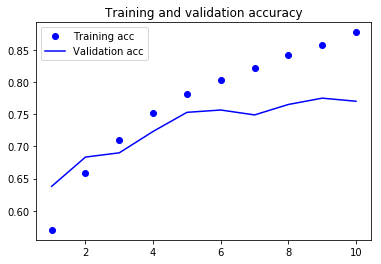

In [11]:
# plot the accuracy rates for each epoch on training and validation data
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

## Finally evaluate on test data

In [12]:
test_loss, test_acc = feedforward_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

25000/25000 [==============================] - 19s 778us/step
Test accuracy: 0.5744


In [13]:
test_loss, test_acc = rnn_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

25000/25000 [==============================] - 276s 11ms/step
Test accuracy: 0.77576
